In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [27]:
# initialize params
seed = 300

num_iters = 1
T = 20  # time horizon
n = 5  # num historical samples
delta = 0.3
alpha = 0 # percentage of time to pull arm 0
mean_arms = [.5, .5-delta]  # note: arm 0 always better
n_arms = len(mean_arms)

RANDOM_REWARD = True
DEBUG = False

In [28]:
np.random.seed(seed)
regret_data = []

def generate_dataset(n, alpha): # NOTE: CURRENTLY SET SO DETERMINISTIC REWARDS SO NO RANDOMNESS IN ARM REWARDS
    """ generate historical samples """
    dataset = {'0': [], '1': []}
    for _ in range(int(alpha*n)):
        if not RANDOM_REWARD: dataset['0'].append(np.random.binomial(p=mean_arms[0], n=1))
        if RANDOM_REWARD: dataset['0'].append(mean_arms[0])
    for _ in range(n - int(alpha*n)):
        if not RANDOM_REWARD: dataset['1'].append(np.random.binomial(p=mean_arms[1], n=1))
        if RANDOM_REWARD: dataset['1'].append(mean_arms[1])
    return dataset

def conf_r(t, n_pulls):
    """ compute confidence radius """
#     return np.sqrt(2*np.log(1+t) / n_pulls)
    return np.sqrt(2*np.log(1+T) / n_pulls)
    

online_use_all_data_count = 0.0
online_data_use_percentage = []

algo_list = ['simple', 'online']

# simple algorithm (Thorsten 2012)
# online algorithm: Wrapper of prototypical UCB algorithm

for i in range(num_iters):
    
    dataset = generate_dataset(n, alpha) # historical dataset
    online_samples = generate_dataset(2*T, .5) # gets samples which are used for the "online" samples
    if DEBUG: print(f'Dataset: {dataset}')
    if DEBUG: print(f'Online Dataset: {online_samples}')

    
    # initialize counters
    offline_data_index   = np.asarray([0,0]) # index of wrapper algorithm in historical samples
    
    regret = {}
    mean   = {}
    select = {}
    ucb = {'simple': [np.inf, np.inf], 'online':[np.inf, np.inf], 'no_history':[np.inf, np.inf]} # ucb index
    algo_index = {'simple': [0,0], 'no_history': [0,0], 'online': [0,0]} # total number of samples
    
    for algo in algo_list: # initializing parameters
        
        regret[algo] = 0 # updates current regret to be zero
        mean[algo]   = np.asarray([0.0, 0.0]) # mean estimates to zero
        select[algo] = np.asarray([0, 0]) # selection frequency to zero
    
        # but the historical samples update the mean / selection to be based on the historical dataset
        mean['simple']   = np.asarray([max(0.0, np.mean(dataset['0'])), max(0.0, np.mean(dataset['1']))])
        select['simple'] = np.asarray([len(dataset['0']), len(dataset['1'])])
    
    for t in range(T+n):
        for algo in algo_list:   
            
            if np.sum(algo_index[algo]) < T: # not finished yet in the experiment
            
            # -----------------------------------
            # pick arm to pull
            # -----------------------------------
                ucb[algo] = np.asarray([mean[algo][arm] + conf_r(np.sum(select[algo])+1, select[algo][arm]) \
                                      if select[algo][arm] > 0 else np.inf for arm in range(n_arms)])
                arm = np.argmax(ucb[algo])

                if DEBUG: print(f'Algo: {algo}, UCB: {ucb[algo]}, arm: {arm}')
                select[algo][arm] += 1

                if algo == 'online' and offline_data_index[arm] < len(dataset[str(arm)]):
                    if DEBUG: print('Online Using Historical Sample')
                    # if we haven't used all offline samples of the chosen arm
                    obs = dataset[str(arm)][offline_data_index[arm]]
                    mean[algo][arm] = (mean[algo][arm] * select[algo][arm] + obs) / (select[algo][arm]+1)
                    offline_data_index[arm] += 1
                    continue # do not penalize regret or use an online sample
                    
                # -----------------------------------
                # get observation and record
                # -----------------------------------
                regret[algo] += mean_arms[0] - mean_arms[arm]
                regret_data.append({'Algo': algo, 'Iter': i, 't': np.sum(algo_index[algo]), 'Arm': arm, 'Regret': regret[algo]})
                obs = online_samples[str(arm)][algo_index[algo][arm]]
                algo_index[algo][arm] += 1
                mean[algo][arm] = (mean[algo][arm]*select[algo][arm] + obs) / (select[algo][arm]+1)

            
    # meta trackers on behavior of online algorithm
    if offline_data_index[0] == len(dataset['0']) and offline_data_index[1] == len(dataset['1']):
        online_use_all_data_count += 1
    
    online_data_use_percentage.append((offline_data_index[0] + offline_data_index[1]) / n)

print('----------------------------')
print('Stats from online algorithm')
print(f'  # pulls of each arm in historical data:     {offline_data_index}')
print(f'  Percentage of trials entire dataset used:   {100 * online_use_all_data_count / num_iters}')
print(f'  Average percentage of historical data used: {100*np.mean(online_data_use_percentage):.2f}')

----------------------------
Stats from online algorithm
  # pulls of each arm in historical data:     [0 5]
  Percentage of trials entire dataset used:   100.0
  Average percentage of historical data used: 100.00


/home/sean/anaconda3/envs/warm_start/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sean/anaconda3/envs/warm_start/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<bound method NDFrame.tail of       Algo  Iter   t  Arm  Regret
0   simple     0   0    0     0.0
1   online     0   0    0     0.0
2   simple     0   1    0     0.0
3   simple     0   2    0     0.0
4   online     0   1    0     0.0
5   simple     0   3    0     0.0
6   simple     0   4    0     0.0
7   online     0   2    0     0.0
8   simple     0   5    0     0.0
9   simple     0   6    0     0.0
10  online     0   3    0     0.0
11  simple     0   7    0     0.0
12  online     0   4    0     0.0
13  simple     0   8    0     0.0
14  simple     0   9    1     0.3
15  online     0   5    0     0.0
16  simple     0  10    0     0.3
17  online     0   6    0     0.0
18  simple     0  11    0     0.3
19  simple     0  12    1     0.6
20  online     0   7    0     0.0
21  simple     0  13    0     0.6
22  online     0   8    0     0.0
23  simple     0  14    0     0.6
24  online     0   9    0     0.0
25  simple     0  15    0     0.6
26  online     0  10    1     0.3
27  simple     0  

Text(0.5, 1.0, 'n = 5, delta = 0.3, alpha = 0')

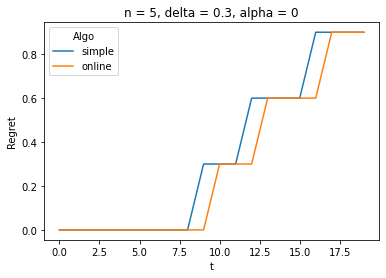

In [29]:
df = pd.DataFrame(regret_data)
print(df.tail)
p = sns.lineplot(data = df, x="t", y="Regret", hue="Algo", ci=None) #, ci="sd")
p.set_title(f"n = {n}, delta = {delta}, alpha = {alpha}") 
